# Chinese Restaurant Process

This code example generates data samples in two dimensions following the Chinese Restaurant Process. As in a *Bayesian mixture* the hyperparameters, that is the mixing coefficients, and the mean and covariance matrix of each component follow themselves a distribution. The number of components, $K$, varies.

<font color='red'> The possibility that a sample is generated by a so far unseen distribution is incorporated. Imagine a Chinese restaurant with the tables where the middle rotates. The first customer sits at a table and orders a selection of food. The food is the distribution. He samples from the food which is the first data sample. The second customer can <b> either </b> sit at the same table and sample from the same food which then is the second sample, <b> or </b> go to a newly opened table and order a different set of food which is then the second distribution from which he samples. Other customers arrive and either sit at already opened table and sample from those foods or more tables are opened up. </font>


If $n-1$ data samples have been generated, the $n$<sup>th</sup> sample is generated by
process $k$ with probability $n_k/(n-1 + \alpha)$ or a new process with probability $\alpha/(n-1 + \alpha)$,
where $n_k$ is the number of samples generated by process $k$ so far. When summing the samples generated by each process over all processes, the result is $n-1$. Therefore the probabilities sum to $1$. As more and more samples are generated by a particular process, it gets more likely that this process will generate further samples, since $n_k / (n-1 + \alpha)$ increases. This is known as *rich-get-richer*.

$\alpha$ id the dispersion, concentration, scaling parameter or strength.

## Import modules

In [1]:
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt

## Generate samples
This is implemented as a function.

In [2]:
def CRP(size,alpha0,mean0,lambda0,scale,df):
    """ Input:
    size:           number of data points to be generated,
    alpha0:         concentration parameter,
    mean0:          location vector,
    lambda0:        mean fraction,
    scale:          scale matrix,
    df:             degrees of freedom.
    Output:
    data:           data vector,
    idx:            index vector which process generated the sample,
    means:          array of the means of all processes,
    covs:           array of the covariance matrices of all processes."""

    # Generate distribution of first process.
    covs = ss.invwishart.rvs(df = df, scale = scale)
    means = np.random.multivariate_normal(mean = mean0, cov = 1/lambda0 * covs)
    # Generate first sample and reshape so that future samples and hyperparameters can be appended.
    data = np.reshape(np.random.multivariate_normal(mean = means, cov = covs),(1,2))
    idx = np.array([0])
    comp_size = np.array([1])
    covs = np.reshape(covs,(2,2,1))
    means = np.reshape(means,(2,1))
    # Initialize the vector of probabilities which process generates a sample or whether a new process is generated.
    p = [1/(1+alpha0),alpha0/(1+alpha0)]
    for n in range(size-1):
        # Sample from which process the next data point is taken or whether a new process is created.
        comp_idx =  np.random.choice(len(p),p=p)
        if comp_idx < len(p)-1:
            # Generate new sample from existing process.
            sample = np.reshape(np.random.multivariate_normal(mean = means[:,comp_idx], cov = covs[:,:,comp_idx]),(1,2))
            data = np.concatenate((data,sample))
            idx = np.concatenate((idx,[comp_idx]))
            comp_size[comp_idx] += 1
        else:
            # Generate mean and covariance of new process.
            cov = ss.invwishart.rvs(df = df, scale = scale)
            mean = np.random.multivariate_normal(mean = mean0, cov = 1/lambda0 * cov)
            # Append these to the means and covariances.
            covs = np.concatenate((covs,np.reshape(cov,(2,2,1))),2)
            means = np.concatenate((means,np.reshape(mean,(2,1))),1)
            # Generate new sample.
            sample = np.reshape(np.random.multivariate_normal(mean = mean, cov = cov),(1,2))
            data = np.concatenate((data,sample))
            idx = np.concatenate((idx,[comp_idx]))
            comp_size = np.concatenate((comp_size,[1]))
        # Update vector of probabilities.
        p = np.concatenate((comp_size/(n+2+alpha0), [alpha0/(n+2+alpha0)]))
    return data, idx, p, means, covs

### Define sample size

In [3]:
sample_size = 1000

## Define hyperparameters
In this example, we use the hyperparameters,
\begin{equation}
\mathbf{m} = \left( 0 \atop 0 \right), \lambda = 1, \boldsymbol{\Psi} = \left(  1 \atop 1.5 \right. \left. 1.5 \atop 3 \right), \nu = 6.
\end{equation}

In [4]:
alpha0 = 0.5
mean0 = np.array([0, 0])
lambda0 = 1;
scale = np.array([[1, 1.5], [1.5, 3]])
df = 6;

### Generate distributions and samples

In [5]:
data, idx, p, means, covs = CRP(size=sample_size,alpha0=alpha0,mean0=mean0,lambda0=lambda0,scale=scale,df=df)
print('Mixing coefficients: ', p, '\n')
n_components = len(p)-1
for i in range(n_components):
    print('Component', i+1)
    print('Mean:', means[:,i])
    print('Covariance:', covs[:,:,i], '\n')

Mixing coefficients:  [4.10794603e-01 5.85707146e-01 1.99900050e-03 9.99500250e-04
 4.99750125e-04] 

Component 1
Mean: [-0.27052715  0.11462843]
Covariance: [[0.16635338 0.26944992]
 [0.26944992 0.63618241]] 

Component 2
Mean: [-0.72558239 -1.92046246]
Covariance: [[0.25118319 0.53287005]
 [0.53287005 1.57168209]] 

Component 3
Mean: [0.08005758 0.63754707]
Covariance: [[0.20134244 0.40388325]
 [0.40388325 1.04583442]] 

Component 4
Mean: [ 0.36545132 -0.39647229]
Covariance: [[0.35750155 0.69652825]
 [0.69652825 1.61657428]] 



### Plot of probability density functions
#### First individually

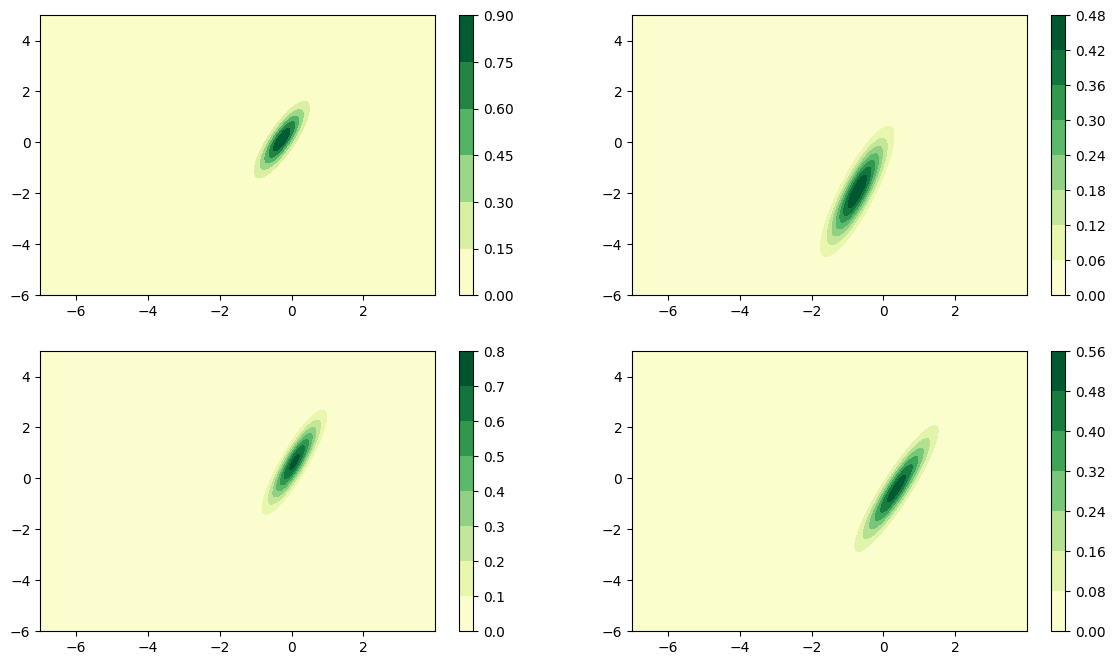

In [6]:
x, y = np.mgrid[-7:4:.01, -6:5:.01]
pos = np.dstack((x, y))
z_all = np.zeros((x.shape[0], x.shape[1]))
cols = 2
rows = np.ceil(n_components/cols).astype(int)
fig = plt.figure(figsize=(14,8))
for i in range(0, n_components):
    ax = fig.add_subplot(rows, cols, i+1)
    z = ss.multivariate_normal.pdf(pos, mean = means[:,i], cov = covs[:,:,i])
    z_all = z_all + z * p[i]
    c = ax.contourf(x, y, z, cmap = plt.cm.YlGn)
    cbar = plt.colorbar(c)
plt.show()

#### Then mixed

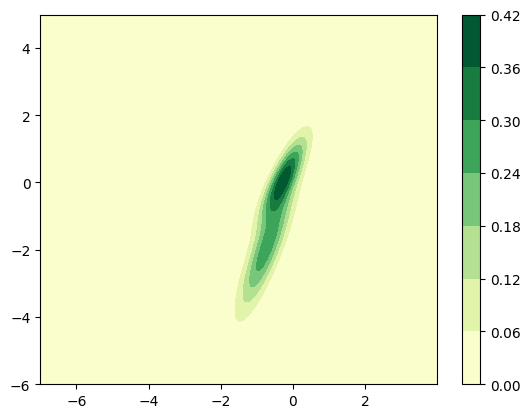

In [7]:
fig = plt.figure()
c = plt.contourf(x, y, z_all, cmap = plt.cm.YlGn)
cbar = plt.colorbar(c)
plt.show()

### Scatter plot of samples

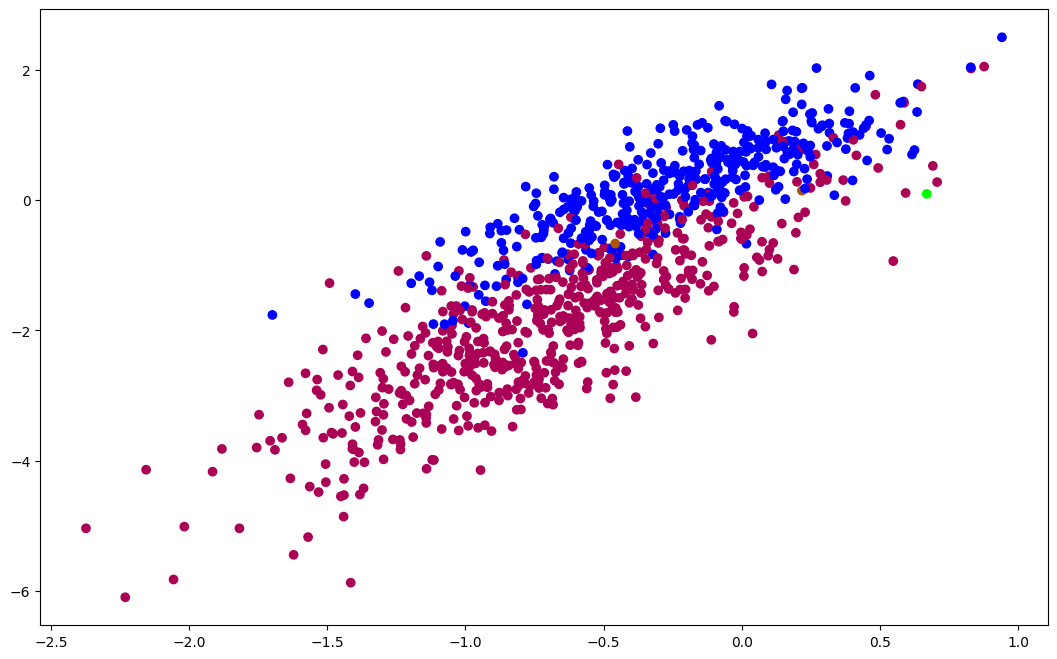

In [8]:
fig = plt.figure(figsize=(13,8))
plt.scatter(data[:,0], data[:,1], c = idx, cmap = plt.cm.brg)
plt.show()

#### Number of samples per component

In [9]:
for i in range(n_components):
    print('Component', i+1, ':', sum(idx==i))

Component 1 : 411
Component 2 : 586
Component 3 : 2
Component 4 : 1


### Explore hyperparameters

Rerun several times setting $\alpha$ to $1/2$ and $2$. You should notice that with smaller $\alpha$ a smaller number of clusters is favoured, while large $\alpha$ generates more clusters in general. Changing the other hyperparameters has similar effects as explored in Bayesian mixtures.